<a href="https://colab.research.google.com/github/JeiGeek/ia1-LosPandas-prediccion_rendimiento_estudiantil/blob/main/02_Supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title **Librerias**
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Partición de dataset
from sklearn.model_selection import train_test_split

# Particion de entrenamiento KFol y tunning
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, KFold, RandomizedSearchCV

# Librerias de modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


# Librerias para reporte de metricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score, matthews_corrcoef, make_scorer, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

# **Carga y ajustes del dataset**

In [ ]:
# Carga desde github
url = "https://raw.githubusercontent.com/JeiGeek/ia1-LosPandas-prediccion_rendimiento_estudiantil/main/Dataset/StudentPerformanceFactors.csv"
df = pd.read_csv(url)

In [ ]:
# Limpieza de nulos y valores fuera del margen
df = df.dropna()
df = df[df['Exam_Score'] <= 100]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6377 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6377 non-null   int64 
 1   Attendance                  6377 non-null   int64 
 2   Parental_Involvement        6377 non-null   object
 3   Access_to_Resources         6377 non-null   object
 4   Extracurricular_Activities  6377 non-null   object
 5   Sleep_Hours                 6377 non-null   int64 
 6   Previous_Scores             6377 non-null   int64 
 7   Motivation_Level            6377 non-null   object
 8   Internet_Access             6377 non-null   object
 9   Tutoring_Sessions           6377 non-null   int64 
 10  Family_Income               6377 non-null   object
 11  Teacher_Quality             6377 non-null   object
 12  School_Type                 6377 non-null   object
 13  Peer_Influence              6377 non-null   object
 1

In [ ]:
# Hay 13 variables de tipo categoricas, se convierten en tipo numericas (se le da un valor ya sea 0 y 1, o 1,2,3)

df_encoded = df.copy()

# Categorizacion binaria para categorias que son solo 2 dos tipos

# get_dummies - Convierte tablas categoricas en binarios
# drop_first - quita la columna redudante que se genera
df_encoded = pd.get_dummies(df_encoded, columns=["Extracurricular_Activities", "Internet_Access", "School_Type", "Learning_Disabilities", "Gender"], drop_first=True)

# Categorizacion por categorias que son de 3 tipos

# para categorias bajo - medio - alto
mapping = {"Low":1, "Medium":2, "High":3}
columnas = ["Parental_Involvement", "Access_to_Resources", "Motivation_Level", "Family_Income", "Teacher_Quality"]

for columna in columnas:
    df_encoded[columna] = df_encoded[columna].map(mapping)

# para categoria negativo - positivo - neutral
mapping = {"Negative":-1, "Positive":1, "Neutral":0}
df_encoded["Peer_Influence"] = df_encoded["Peer_Influence"].map(mapping)

# para categoria High School - College - Postgraduate
mapping = {"High School":1, "College":2, "Postgraduate":3}
df_encoded["Parental_Education_Level"] = df_encoded["Parental_Education_Level"].map(mapping)

# para categoria Near - Moderate - Far
mapping = {"Near":1, "Moderate":2, "Far":3}
df_encoded["Distance_from_Home"] = df_encoded["Distance_from_Home"].map(mapping)


# Convertir las columnas booleanas resultantes en 0 y 1
bool_cols = df_encoded.select_dtypes(include=["bool"]).columns # Se seleccionan las columnas solamente las columnas booleanas
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int) # Se convierten en 0 y 1

# PCA

# **Consideraciones de metricas para Regresión**

Usamos MSE y MAE como métricas porque nos permiten medir la precisión del modelo al comparar las predicciones con los valores reales, pero cada una tiene propósitos y características diferentes.


*   MAE muestra cuánto se equivoca el modelo en promedio, en las mismas unidades del dato.
*   MSE mide el promedio de los errores al cuadrado, dando más peso a los errores grandes.



# **Consideraciones de metricas para Clasificacion**

Para evaluar el desempeño del modelo se emplean las métricas Balanced Accuracy, Matthews Correlation Coefficient (MCC) y el Classification Report, que incluye precision, recall y F1-score. Estas métricas permiten medir no solo la precisión global, sino también el equilibrio y la calidad de las predicciones en un dataset desbalanceado.



`1.   Balanced Accuracy (Exactitud Balanceada):`

Mide el promedio entre la sensibilidad (recall) de la clase positiva y la clase negativa. Es útil cuando las clases están desbalanceadas, ya que da igual peso a ambas.

**Interpretación:**

Un valor cercano a 1 indica que el modelo predice bien ambas clases; valores cercanos a 0.5 reflejan un desempeño similar al azar.



`2.   Matthews Correlation Coefficient (MCC)`

Evalúa la correlación entre las predicciones y los valores reales, considerando todas las categorías de la matriz de confusión (TP, TN, FP, FN). Es una métrica robusta para datasets desbalanceados.

Interpretación:



*   1: predicciones perfectas.
*   0: predicciones aleatorias.
*   −1: predicciones totalmente erróneas.

`3.  Classification Report (Precision, Recall y F1-score)`

Proporciona una visión detallada del rendimiento por clase:

* Precisíon (Precisíon): Mide la proporción de verdaderos positivos entre todas las predicciones positivas. `(Indica qué tan confiables son las predicciones positivas del modelo.)`

* Exhaustividad (Recall o Sensibilidad): Mide la proporción de verdaderos positivos identificados correctamente `(Evalúa la capacidad del modelo para detectar todos los casos reales positivos)`

* F1-score:
Es la media armónica entre precisión y recall, equilibrando ambas métricas `(Es útil cuando hay desbalance de clases.)`

# **Regresión**

---

In [ ]:
#@title Primera partición de dataset para evaluar y evitar sobre entrenamiento

# Copia del DataFrame
df_r = df_encoded.copy()

# Variables predictoras (todas menos Exam_Score)
X = df_r.drop(['Exam_Score'], axis=1)

# Variable objetivo
y = df_r['Exam_Score']

# Partición inicial Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80% train - 20% test
    random_state=42
)


In [ ]:
# @title Función de regresion
def flujo_regresion(modelo, param_grid, score, X_train, X_test, y_train, y_test):

  # Validación cruzada
  cv = KFold(n_splits=5, shuffle=True, random_state=42)

  # Tuning con grid_search
  grid = GridSearchCV(
      estimator=modelo,
      param_grid=param_grid,
      cv=cv,
      scoring= score,
      n_jobs=-1,
      return_train_score=True
  )

  # Entrenamiento del GridSearch
  grid.fit(X_train, y_train)

  # Obtención del mejor modelo
  mejor_modelo = grid.best_estimator_

  # Metricas de cada fold del mejor modelo
  scores_folds = cross_val_score(
      mejor_modelo, X_train, y_train,
      cv=cv,
      scoring= score
  )

  # Entrenamiento del modelo fina con todo el x_train y evaluar con el test
  mejor_modelo.fit(X_train, y_train)
  y_pred = mejor_modelo.predict(X_test)

  absolte_error = mean_absolute_error(y_test, y_pred)
  mean_squared = mean_squared_error(y_test, y_pred)

  # Importancia de columnas
  try: # manejo de error para el SVC
    importantes = pd.DataFrame({
        'Columna': X_train.columns,
        'Importancia': mejor_modelo.feature_importances_
    })
  except AttributeError:
    result = permutation_importance(
        mejor_modelo, X_test, y_test,
        scoring=score,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    importantes = pd.DataFrame({
        'Columna': X_train.columns,
        'Importancia': result.importances_mean
    })

  return grid, scores_folds, absolte_error, mean_squared, importantes, y_pred

## **Decision Tree**

In [ ]:
# Modelo base
tree = DecisionTreeRegressor(random_state=42)

# Espacio de hiperparámetros para el tuning
param_grid = {
    'max_depth': [1, 2, 3, 5, 7, 10, 20, 30, 50, 100, None]
}

In [ ]:
# Metrica de mejora del modelo
score = make_scorer(mean_absolute_error, greater_is_better=False)
# Llamado de la función
grid, scores_folds, absolte_error, mean_squared, importantes, y_pred = flujo_regresion(tree, param_grid, score, X_train, X_test, y_train, y_test)

In [ ]:
# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor evaluación promedio:", -grid.best_score_)

Mejores hiperparámetros: {'max_depth': 7}
Mejor evaluación promedio: 1.6375252192037189


In [ ]:
# Evaluaciónde cada fold del mejor modelo encontrado
print("Evaluación en cada fold del mejor modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {-score:.4f}")

print("\nPromedio:", -scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Evaluación en cada fold del mejor modelo:
Fold 1: 1.5219
Fold 2: 1.6387
Fold 3: 1.6293
Fold 4: 1.6559
Fold 5: 1.7418

Promedio: 1.6375 | Desviación estándar: 0.0702


In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("MAE:", round(absolte_error, 4))
print("MSE:", round(mean_squared, 4))

Evaluación final:
MAE: 1.6944
MSE: 9.7758


###**¿Todas mis columnas son importantes?**

In [ ]:
display(importantes.sort_values(by='Importancia', ascending=False))
importantes_copy = importantes.sort_values(by='Importancia', ascending=False).copy()

,Columna,Importancia
1,Attendance,0.504710
0,Hours_Studied,0.310297
5,Previous_Scores,0.043296
2,Parental_Involvement,0.039106
3,Access_to_Resources,0.022036
4,Sleep_Hours,0.016808
11,Physical_Activity,0.014197
7,Tutoring_Sessions,0.013558
13,Distance_from_Home,0.009088
8,Family_Income,0.009040


In [ ]:
# Rango ajustable
min_importancia = 0.02 # valor mínimo

# Filtrado las columnas dentro del rango
features_filtradas = importantes_copy[
    (importantes_copy["Importancia"] >= min_importancia)
]["Columna"]

# Filtrado el dataset original X
X_filtrado = X[features_filtradas].copy()

display(X_filtrado.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6377 entries, 0 to 6606
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Attendance            6377 non-null   int64
 1   Hours_Studied         6377 non-null   int64
 2   Previous_Scores       6377 non-null   int64
 3   Parental_Involvement  6377 non-null   int64
 4   Access_to_Resources   6377 non-null   int64
dtypes: int64(5)
memory usage: 298.9 KB


None

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y,
    test_size=0.2,
    random_state=42
)

In [ ]:
score2 = make_scorer(mean_absolute_error, greater_is_better=False)
grid, scores_folds, absolte_error, mean_squared, importantes2, y_pred = flujo_regresion(tree, param_grid, score2, X_train, X_test, y_train, y_test)

In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("MAE:", round(absolte_error, 4))
print("MSE:", round(mean_squared, 4))

Evaluación final:
MAE: 1.6321
MSE: 8.4604


La evaluaciuon final nos dice que al reducir las variables a solo las más relevantes (**Attendance**, **Hours_Studied**, **Previous_Scores**, **Parental_Involvement** y **Access_to_Resources**), el modelo mejorara su precisión (MAE = 1.6321, MSE = 8.4604).

En este caso, un MAE = 1.6321 significa que, en promedio, el modelo se equivoca en aproximadamente 1.63 unidades respecto al valor real de la variable objetivo. Dando a entender que el modelo tiene una precision bastante buena, ya que el margen promedio de error es pequeño en relación con la escala total de los datos

Un MSE = 8.4604 indica que, en promedio, la magnitud cuadrática de los errores es baja, lo que significa que no hay errores extremos o muy altos en las predicciones. Además, si tomamos la raíz cuadrada del MSE (es decir, el RMSE), obtendremos un valor de 2.91
Eso quiere decir que el error típico del modelo es de aproximadamente 2.91 unidades respecto al valor real.

El modelo no solo mejora respecto al anterior, sino que logra un equilibrio entre simplicidad y exactitud.

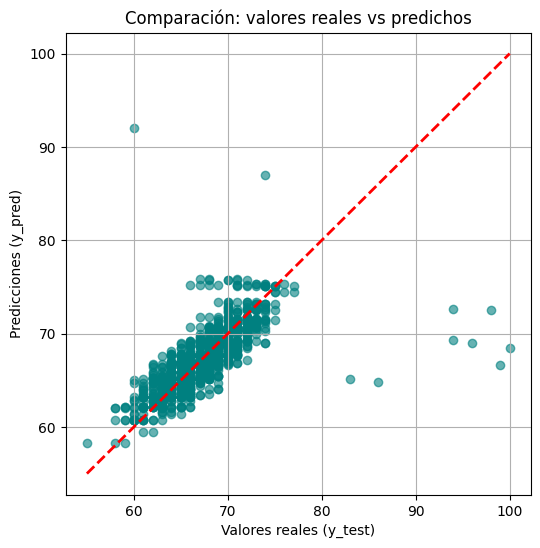

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)  # línea ideal (predicción perfecta)

plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Comparación: valores reales vs predichos")
plt.grid(True)
plt.show()

## **Random Forest**

In [ ]:
# Modelo base
random = RandomForestRegressor(random_state=42)

# Espacio de hiperparámetros para el tuning
param_grid = {
    # Acotado por tiempo de ejecución muy lento
    'n_estimators': [100, 200], # numero de arboles a realizar
    'max_depth': [20, 30, 40, None]
}

In [ ]:
# Metrica de mejora del modelo
score = make_scorer(mean_absolute_error, greater_is_better=False)
# Llamado de la función
grid, scores_folds, absolte_error, mean_squared, importantes, y_pred = flujo_regresion(random, param_grid, score, X_train, X_test, y_train, y_test)

In [ ]:
# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor evaluación promedio:", -grid.best_score_)

Mejores hiperparámetros: {'max_depth': 20, 'n_estimators': 200}
Mejor evaluación promedio: 1.1437885249721753


In [ ]:
# Evaluaciónde cada fold del mejor modelo encontrado
print("Evaluación en cada fold del mejor modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {-score:.4f}")

print("\nPromedio:", -scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Evaluación en cada fold del mejor modelo:
Fold 1: 1.0355
Fold 2: 1.1698
Fold 3: 1.1604
Fold 4: 1.1737
Fold 5: 1.1796

Promedio: 1.1438 | Desviación estándar: 0.0545


In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("MAE:", round(absolte_error, 4))
print("MSE:", round(mean_squared, 4))

Evaluación final:
MAE: 1.1055
MSE: 5.7006


###**¿Todas mis columnas son importantes?**

In [ ]:
display(importantes.sort_values(by='Importancia', ascending=False))
importantes_copy = importantes.sort_values(by='Importancia', ascending=False).copy()

,Columna,Importancia
1,Attendance,0.378112
0,Hours_Studied,0.248527
5,Previous_Scores,0.087394
2,Parental_Involvement,0.035193
3,Access_to_Resources,0.034050
7,Tutoring_Sessions,0.031158
11,Physical_Activity,0.027377
4,Sleep_Hours,0.025195
8,Family_Income,0.020349
13,Distance_from_Home,0.016135


In [ ]:
# Rango ajustable
min_importancia = 0.0069 # valor mínimo

# Filtrado las columnas dentro del rango
features_filtradas = importantes_copy[
    (importantes_copy["Importancia"] >= min_importancia)
]["Columna"]

# Filtrado el dataset original X
X_filtrado = X[features_filtradas].copy()

display(X_filtrado.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6377 entries, 0 to 6606
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Attendance                      6377 non-null   int64
 1   Hours_Studied                   6377 non-null   int64
 2   Previous_Scores                 6377 non-null   int64
 3   Parental_Involvement            6377 non-null   int64
 4   Access_to_Resources             6377 non-null   int64
 5   Tutoring_Sessions               6377 non-null   int64
 6   Physical_Activity               6377 non-null   int64
 7   Sleep_Hours                     6377 non-null   int64
 8   Family_Income                   6377 non-null   int64
 9   Distance_from_Home              6377 non-null   int64
 10  Parental_Education_Level        6377 non-null   int64
 11  Peer_Influence                  6377 non-null   int64
 12  Teacher_Quality                 6377 non-null   int64
 13  Motivati

None

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y,
    test_size=0.2,
    random_state=42
)

In [ ]:
score2 = make_scorer(mean_absolute_error, greater_is_better=False)
grid, scores_folds, absolte_error, mean_squared, importantes2, y_pred = flujo_regresion(random, param_grid, score2, X_train, X_test, y_train, y_test)

In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("MAE:", round(absolte_error, 4))
print("MSE:", round(mean_squared, 4))

Evaluación final:
MAE: 1.0972
MSE: 5.6633



El modelo inicial tenía 19 variables (0 - 18), tras filtrarlo obtuvimos 18 variables para trabajar(La variable eliminada fue Gender_Male). Esto significa que la variable género no aportaba información relevante para predecir el rendimiento estudiantil.
Al eliminarla, el modelo se concentró en las variables realmente influyentes (como Attendance o Hours_Studied), lo que redujo el ruido y mejoró ligeramente la precisión y estabilidad del modelo.

Con esto los resultados finales fueron:

*   MAE = 1.0972
*   MSE = 5.6633

Estos valores son ligeramente menores que los obtenidos antes del filtrado (MAE = 1.1055, MSE = 5.7006).

El MAE nos dice que, en promedio, las predicciones del modelo se desvían 1.0972 unidades del valor real.Además, el hecho de que el MAE bajara frente al modelo anterior (de 1.1055 → 1.0972) significa que las predicciones se acercaron más a los valores reales tras eliminar variables irrelevantes.

El MSE bajo indica que el modelo no solo acierta en promedio, sino que también evita cometer errores muy grandes o extremos. Al bajar de 5.7006 → 5.6633, significa que las predicciones se volvieron más estables, sin valores atípicos de error pronunciados.

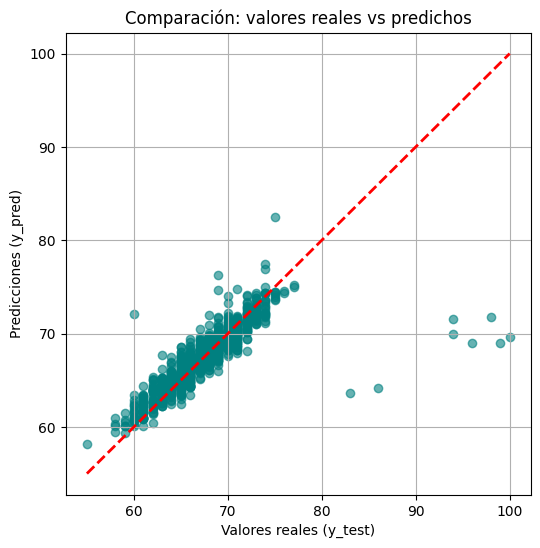

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)  # línea ideal (predicción perfecta)

plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Comparación: valores reales vs predichos")
plt.grid(True)
plt.show()

## **Support Vector Machine**

In [ ]:
# Modelo base
svr = SVR()

# Definición del grid de hiperparámetros
param_grid = {
    'kernel': ['rbf','sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

In [ ]:
# Metrica de mejora del modelo
score = make_scorer(mean_absolute_error, greater_is_better=False)
# Llamado de la función
grid, scores_folds, absolte_error, mean_squared, importantes2, y_pred = flujo_regresion(svr, param_grid, score, X_train, X_test, y_train, y_test)

In [ ]:
# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor evaluación promedio:", -grid.best_score_)

Mejores hiperparámetros: {'gamma': 0.001, 'kernel': 'rbf'}
Mejor evaluación promedio: 0.6500471053963317


In [ ]:
# Evaluaciónde cada fold del mejor modelo encontrado
print("Evaluación en cada fold del mejor modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {-score:.4f}")

print("\nPromedio:", -scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Evaluación en cada fold del mejor modelo:
Fold 1: 0.5429
Fold 2: 0.7069
Fold 3: 0.6457
Fold 4: 0.6778
Fold 5: 0.6769

Promedio: 0.65 | Desviación estándar: 0.057


In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("MAE:", round(absolte_error, 4))
print("MSE:", round(mean_squared, 4))

Evaluación final:
MAE: 0.5832
MSE: 4.32


###**¿Todas mis columnas son importantes?**

In [ ]:
display(importantes2.sort_values(by='Importancia', ascending=False))
importantes_copy = importantes2.sort_values(by='Importancia', ascending=False).copy()

,Columna,Importancia
1,Attendance,2.232782
0,Hours_Studied,1.625411
5,Previous_Scores,0.494139
2,Parental_Involvement,0.403048
3,Access_to_Resources,0.392648
7,Tutoring_Sessions,0.368284
12,Parental_Education_Level,0.182955
10,Peer_Influence,0.154224
8,Family_Income,0.139466
6,Motivation_Level,0.126532


In [ ]:
# Rango ajustable
min_importancia = 0.01 # valor mínimo

# Filtrado las columnas dentro del rango
features_filtradas = importantes_copy[
    (importantes_copy["Importancia"] >= min_importancia)
]["Columna"]

# Filtrado el dataset original X
X_filtrado = X[features_filtradas].copy()

display(X_filtrado.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6377 entries, 0 to 6606
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Attendance                      6377 non-null   int64
 1   Hours_Studied                   6377 non-null   int64
 2   Previous_Scores                 6377 non-null   int64
 3   Parental_Involvement            6377 non-null   int64
 4   Access_to_Resources             6377 non-null   int64
 5   Tutoring_Sessions               6377 non-null   int64
 6   Parental_Education_Level        6377 non-null   int64
 7   Peer_Influence                  6377 non-null   int64
 8   Family_Income                   6377 non-null   int64
 9   Motivation_Level                6377 non-null   int64
 10  Distance_from_Home              6377 non-null   int64
 11  Teacher_Quality                 6377 non-null   int64
 12  Physical_Activity               6377 non-null   int64
 13  Extracur

None

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y,
    test_size=0.2,
    random_state=42
)

In [ ]:
# Llamado de la función
score2 = make_scorer(mean_absolute_error, greater_is_better=False)
grid, scores_folds, absolte_error, mean_squared, importantes2, y_pred = flujo_regresion(svr, param_grid, score2, X_train, X_test, y_train, y_test)

In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("MAE:", round(absolte_error, 4))
print("MSE:", round(mean_squared, 4))

Evaluación final:
MAE: 0.5817
MSE: 4.3163


En la evaluacion final obtenemso los valores:
*   MAE = 0.5817
*   MSE = 4.3163

Esto significa que, en promedio: El modelo se equivoca apenas 0.58 unidades respecto al valor real (MAE). Los errores grandes son muy poco frecuentes, ya que el MSE también es bajo (4.31).

Aunque el MAE y el MSE cambiaron muy poco tras eliminar algunas variables, eso no significa que no haya mejora, sino que:


*   El modelo ya estaba aprendiendo bien con las variables más relevantes.
*   Las variables eliminadas no aportaban información nueva, o incluso podían estar introduciendo ruido (es decir, datos poco útiles que distraen al modelo).
*   Al quitarlas, el modelo se vuelve más simple, rápido y fácil de interpretar, sin perder capacidad predictiva.

Entonces, ¿cambia algo si las quitamos o no, teniendo en cuenta el poco cambio que hay?
Para responder a esa pregunta, debemos considerar la dificultad de obtener esas variables.

Al aplicar el filtro min_importancia = 0.01, quedaron 16 columnas de las 19 originales.
Por lo tanto, se eliminaron 3 variables: `School_Type_Public, Gender_Male y Sleep_Hours`




¿Son entonces esas tres variables difíciles de obtener?
Sí, pueden ser variables de menor utilidad o más complicadas de recolectar con fiabilidad, porque:

* Sleep_Hours depende de la autopercepción del estudiante o de encuestas que pueden no ser exactas.

* Gender y School_Type son variables demográficas simples, pero con bajo poder predictivo, ya que no afectan directamente la forma en que el estudiante estudia o accede a los recursos.

Por lo tanto, eliminarlas no solo simplifica el modelo, sino que también evita costos o sesgos innecesarios en la recolección de datos.

# **Clasificacion por puntaje mayor igual a *70***

---

In [ ]:
# Preparacion de del dataset

# copia del DataFrame
df_60 = df_encoded.copy()

# Agregar la columna booleana de aprobados si tiene valor mayor igual a 70
df_60['Aprobados'] = df_60['Exam_Score'] >= 70

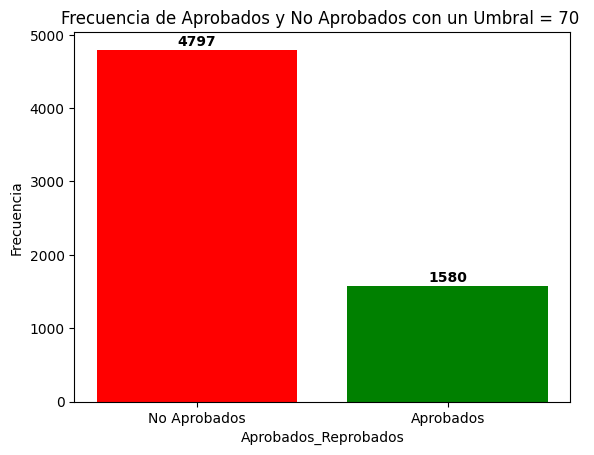

In [ ]:
# @title Visualización de datos por categoría

# Frecuencias por categoría
categorias = df_60['Aprobados'].value_counts()

# Colores para True y False
colores = ['green' if valor else 'red' for valor in categorias.index]

etiquetas = ['Aprobados' if valor else 'No Aprobados' for valor in categorias.index]
plt.bar(etiquetas, categorias.values, color=colores)

# Añadir los valores encima de cada barra
for i, v in enumerate(categorias.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')  # el +50 es para que no se superponga

# Títulos y etiquetas
plt.title('Frecuencia de Aprobados y No Aprobados con un Umbral = 70 ')
plt.xlabel('Aprobados_Reprobados')
plt.ylabel('Frecuencia')

plt.show()

El umbral de 70 genera un claro desbalance en el dataset, con muchos más no aprobados (4797) que aprobados (1580). Esto puede sesgar al modelo hacia la clase mayoritaria, haciendo que prediga con más frecuencia “No Aprobado” y reduciendo su capacidad para identificar correctamente a los estudiantes que sí aprueban.

In [ ]:
#@title Primera partición de dataset para evaluar y evitar sobre entrenamiento
X = df_60.drop(['Exam_Score','Aprobados'], axis=1)
y = df_60['Aprobados']

# Partición inicial Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80 train - 20 test
    stratify=y,          # mantiene proporciones del desbalance
    random_state=42
)

In [ ]:
# @title Función de clasificación
def flujo_clasificacion(modelo, param_grid, X_train, X_test, y_train, y_test):

  # Validación cruzada
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  # Tuning con grid_search
  grid = GridSearchCV(
      estimator=modelo,
      param_grid=param_grid,
      cv=cv,
      scoring='balanced_accuracy',
      n_jobs=-1,
      return_train_score=True
  )

  # Entrenamiento del GridSearch
  grid.fit(X_train, y_train)

  # Obtención del mejor modelo
  mejor_modelo = grid.best_estimator_

  # Metricas de cada fold del mejor modelo
  scores_folds = cross_val_score(
      mejor_modelo, X_train, y_train,
      cv=cv,
      scoring=make_scorer(balanced_accuracy_score)
  )

  # Entrenamiento del modelo fina con todo el x_train y evaluar con el test
  mejor_modelo.fit(X_train, y_train)
  y_pred = mejor_modelo.predict(X_test)

  balanced_acc_final = balanced_accuracy_score(y_test, y_pred)
  mcc_final = matthews_corrcoef(y_test, y_pred)


  # Calculo de otras metricas
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f_1 = f1_score(y_test, y_pred)


  # Importancia de columnas
  try: # manejo de error para el SVC
    importantes = pd.DataFrame({
        'Columna': X_train.columns,
        'Importancia': mejor_modelo.feature_importances_
    })
  except AttributeError:
    result = permutation_importance(
        mejor_modelo, X_test, y_test,
        scoring='balanced_accuracy',
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    importantes = pd.DataFrame({
        'Columna': X_train.columns,
        'Importancia': result.importances_mean
    })

  # Calcular matriz de confusión
  cm = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = cm.ravel()

  # Cálculo de especificidad
  specificity = tn / (tn + fp)

  return grid, scores_folds, balanced_acc_final, mcc_final, precision, recall, f_1, specificity, classification_report(y_test, y_pred, zero_division=0), cm, importantes

## **Gaussian Bayes**

In [ ]:
# Modelo base
model = GaussianNB()

# Validación cruzada con StratifiedKFold SOLO CON ENTRENAMIENTOS
# Con 5 splits de organizacion
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Obtencion de los resultados de la validación cruzada con metricas puntuales
scores_folds = cross_val_score(
    model, X_train, y_train,
    cv=cv,
    scoring=make_scorer(balanced_accuracy_score)
)

# Balanced accuracy de cada fold del mejor modelo encontrado
print("Balanced Accuracy en cada fold del modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {score:.4f}")

print("\nPromedio:", scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Balanced Accuracy en cada fold del modelo:
Fold 1: 0.8591
Fold 2: 0.8547
Fold 3: 0.8684
Fold 4: 0.8743
Fold 5: 0.8841

Promedio: 0.8681 | Desviación estándar: 0.0105


In [ ]:
# Entrenamiento del modelo fina con todo el x_train y evaluar con el test
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

balanced_acc_final = balanced_accuracy_score(y_test, y_pred)
mcc_final = matthews_corrcoef(y_test, y_pred)

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Cálculo de especificidad
specificity = tn / (tn + fp)

# Calculo de otras metricas
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

# Evaluacion final
print("Evaluación final:\n")
print("Balanced Accuracy:", round(balanced_acc_final, 4))

print("Recall:", round(recall, 4))
print("Especificidad:", round(specificity, 4))
print("Precision:", round(precision, 4))
print("F1-Score:", round(f_1, 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Evaluación final:

Balanced Accuracy: 0.8783
Recall: 0.7785
Especificidad: 0.9781
Precision: 0.9213
F1-Score: 0.8439

Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.98      0.95       960
        True       0.92      0.78      0.84       316

    accuracy                           0.93      1276
   macro avg       0.93      0.88      0.90      1276
weighted avg       0.93      0.93      0.93      1276



La métrica de Balanced Accuracy (0.8783) combina la sensibilidad (recall) y la especificidad en un promedio, equilibrando el efecto del desbalance. Indica que el modelo tiene una capacidad global del 87,8% para identificar correctamente tanto a los aprobados como a los no aprobados, sin favorecer a la clase mayoritaria.

El Recall (0.7785) mide la proporción de estudiantes aprobados que el modelo logró identificar correctamente. En este caso, el 77,85% de los que aprobaron fueron detectados como tales, lo que significa que el modelo deja escapar cerca del 22% de los aprobados (falsos negativos).

La Especificidad (0.9781) refleja qué tan bien el modelo distingue a los no aprobados, y con casi un 98% demuestra que predice con mucha precisión quiénes no aprueban. Esto se relaciona directamente con el desbalance del dataset, ya que el modelo está muy seguro al reconocer la clase dominante.

La Precisión (0.9213) muestra qué tan confiables son las predicciones positivas. Es decir, cuando el modelo dice que un estudiante aprueba, en el 92% de los casos tiene razón. Este valor alto indica pocos falsos positivos.

Finalmente, el F1-Score (0.8439) representa un equilibrio entre la precisión y el recall, por lo que resume la calidad general de las predicciones para la clase minoritaria (aprobados). Un valor de 0.84 es muy bueno en un contexto desbalanceado, ya que indica que el modelo mantiene un buen compromiso entre no dejar escapar demasiados aprobados y no clasificarlos erróneamente.

En conjunto, estas métricas muestran que el modelo Gaussian Naive Bayes se desempeña de forma sólida: reconoce muy bien a los no aprobados, mantiene un buen nivel de detección de aprobados y conserva un equilibrio general entre ambas clases sin verse sesgado por el desbalance.

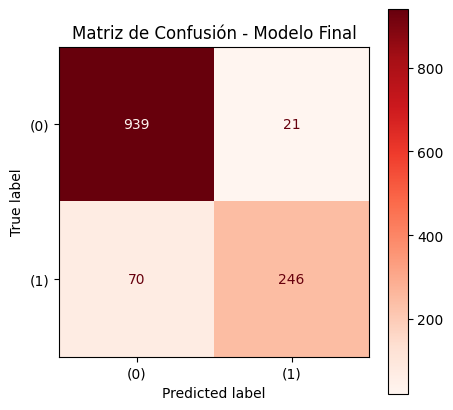

In [ ]:
# Creacion de la matriz de confusión
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["(0)", "(1)"]
)

# Graficar
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(
    cmap="Reds",
    values_format="d",
    ax=ax
)
plt.title("Matriz de Confusión - Modelo Final")
plt.show()

Analisis



1.   El modelo predijo correctamente 939 de los 960 estudiantes que realmente no aprobaron, lo cual explica su alta especificidad (0.9781).
2.   También identificó correctamente 246 de los 316 aprobados, lo que coincide con un recall de 0.7785.
3. Solo 21 estudiantes fueron clasificados erróneamente como aprobados cuando no lo eran (falsos positivos), y 70 fueron clasificados como no aprobados cuando sí aprobaron (falsos negativos).





La matriz de confusión muestra que el modelo tiene un excelente rendimiento al reconocer a los no aprobados, y un desempeño también sólido al detectar a los aprobados, aunque con cierta pérdida (70 casos no detectados).

El modelo es muy conservador: prefiere “fallar por exceso de prudencia” (clasificar a alguien que aprobó como no aprobado) antes que equivocarse diciendo que alguien aprobó cuando no lo hizo.

## **Decision Tree**

In [ ]:
# Modelo base
tree = DecisionTreeClassifier(random_state=42)

# Espacio de hiperparámetros para el tuning
param_grid = {
    'max_depth': [1, 2, 3, 5, 7, 10, 20, 30, 50, 100, None]
}

In [ ]:
# Llamado de la función
grid, scores_folds, balanced_acc_final, mcc_final, precision, recall, f_1, specificity, report, cm, importantes = flujo_clasificacion(tree, param_grid, X_train, X_test, y_train, y_test)

In [ ]:
# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor balanced accuracy promedio:", grid.best_score_)

Mejores hiperparámetros: {'max_depth': 10}
Mejor balanced accuracy promedio: 0.8204017268771207


In [ ]:
# Balanced accuracy de cada fold del mejor modelo encontrado
print("Balanced Accuracy en cada fold del mejor modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {score:.4f}")

print("\nPromedio:", scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Balanced Accuracy en cada fold del mejor modelo:
Fold 1: 0.8076
Fold 2: 0.8188
Fold 3: 0.8192
Fold 4: 0.8120
Fold 5: 0.8443

Promedio: 0.8204 | Desviación estándar: 0.0127


In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:\n")
print("Balanced Accuracy:", round(balanced_acc_final, 4))

print("Recall:", round(recall, 4))
print("Especificidad:", round(specificity, 4))
print("Precision:", round(precision, 4))
print("F1-Score:", round(f_1, 4))
print("\nClassification Report:")
print(report)

Evaluación final:

Balanced Accuracy: 0.818
Recall: 0.7184
Especificidad: 0.9177
Precision: 0.7418
F1-Score: 0.7299

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.92      0.91       960
        True       0.74      0.72      0.73       316

    accuracy                           0.87      1276
   macro avg       0.83      0.82      0.82      1276
weighted avg       0.87      0.87      0.87      1276



###**¿Todas mis columnas son importantes?**

In [ ]:
display(importantes.sort_values(by='Importancia', ascending=False))
importantes_copy = importantes.sort_values(by='Importancia', ascending=False).copy()

,Columna,Importancia
1,Attendance,0.365878
0,Hours_Studied,0.230316
5,Previous_Scores,0.091561
3,Access_to_Resources,0.059863
7,Tutoring_Sessions,0.053239
2,Parental_Involvement,0.043545
12,Parental_Education_Level,0.031610
11,Physical_Activity,0.020804
10,Peer_Influence,0.018085
13,Distance_from_Home,0.016170


In [ ]:
# Rango ajustable
min_importancia = 0.01 # valor mínimo

# Filtrado las columnas dentro del rango
features_filtradas = importantes_copy[
    (importantes_copy["Importancia"] >= min_importancia)
]["Columna"]

# Filtrado el dataset original X
X_filtrado = X[features_filtradas].copy()

display(X_filtrado.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6377 entries, 0 to 6606
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Attendance                6377 non-null   int64
 1   Hours_Studied             6377 non-null   int64
 2   Previous_Scores           6377 non-null   int64
 3   Access_to_Resources       6377 non-null   int64
 4   Tutoring_Sessions         6377 non-null   int64
 5   Parental_Involvement      6377 non-null   int64
 6   Parental_Education_Level  6377 non-null   int64
 7   Physical_Activity         6377 non-null   int64
 8   Peer_Influence            6377 non-null   int64
 9   Distance_from_Home        6377 non-null   int64
 10  Teacher_Quality           6377 non-null   int64
 11  Motivation_Level          6377 non-null   int64
 12  Family_Income             6377 non-null   int64
dtypes: int64(13)
memory usage: 697.5 KB


None

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y,
    test_size=0.2,       # 80 train - 20 test
    stratify=y,          # mantiene proporciones del desbalance
    random_state=42
)

In [ ]:
grid, scores_folds, balanced_acc_final, mcc_final, precision, recall, f_1, specificity, report, cm, importantes2 = flujo_clasificacion(tree, param_grid, X_train, X_test, y_train, y_test)

In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:\n")
print("Balanced Accuracy:", round(balanced_acc_final, 4))

print("Recall:", round(recall, 4))
print("Especificidad:", round(specificity, 4))
print("Precision:", round(precision, 4))
print("F1-Score:", round(f_1, 4))
print("\nClassification Report:")
print(report)

Evaluación final:

Balanced Accuracy: 0.8312
Recall: 0.7373
Especificidad: 0.925
Precision: 0.7639
F1-Score: 0.7504

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.93      0.92       960
        True       0.76      0.74      0.75       316

    accuracy                           0.88      1276
   macro avg       0.84      0.83      0.84      1276
weighted avg       0.88      0.88      0.88      1276



El modelo de árbol de decisión obtuvo un buen desempeño general en la clasificación.
El Balanced Accuracy (0.8312) muestra que el modelo mantiene un equilibrio adecuado al reconocer tanto los casos positivos como los negativos, incluso cuando las clases están desbalanceadas.
El Recall (0.7373) indica que el modelo logra identificar correctamente cerca del 74% de los casos positivos reales, mientras que la Especificidad (0.925) refleja que acierta en más del 92% de los casos negativos.
Por su parte, la Precisión (0.7639) señala que, cuando el modelo predice un caso positivo, acierta el 76% de las veces. Finalmente, el F1-Score (0.7504) muestra un buen equilibrio entre precisión y recall, lo que significa que el modelo mantiene un rendimiento estable y confiable en ambas clases.

En conjunto, estos resultados indican que el modelo es consistente, equilibrado y generaliza bien, es decir, no se queda solo con los patrones del entrenamiento sino que también funciona correctamente con datos nuevos

Al eliminar las variables con importancia menor a 0.01, el modelo mejoró su rendimiento.
Esto ocurre porque las variables poco relevantes suelen aportar ruido o información redundante, lo que puede confundir al modelo y hacerlo menos preciso.
Al quedarse solo con las variables más influyentes, el árbol se vuelve más claro, sencillo y eficiente, lo que mejora su capacidad para clasificar correctamente.

Además, muchas de las variables eliminadas suelen ser difíciles de obtener o medir en la práctica, como por ejemplo el acceso a internet, la participación en actividades extracurriculares o si el estudiante tiene alguna discapacidad de aprendizaje.
Por eso, al retirarlas, no solo se mejora la calidad del modelo sino también su aplicabilidad real, ya que se basa en información más accesible y confiable.

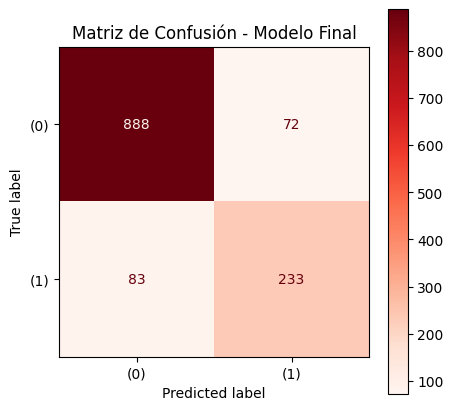

In [ ]:
# Creacion de la matriz de confusión
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["(0)", "(1)"]
)

# Graficar
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(
    cmap="Reds",
    values_format="d",
    ax=ax
)
plt.title("Matriz de Confusión - Modelo Final")
plt.show()

La matriz de confusión muestra cómo se comportó el modelo al clasificar los casos del conjunto de prueba.

Esto nos indica que el modelo tiene un buen nivel de acierto general, ya que la mayoría de las predicciones caen en la diagonal principal (los aciertos).
Sin embargo, se observa una ligera tendencia a confundir algunos casos positivos, lo cual se refleja en los 83 falsos negativos.

En pocas palabras, el modelo reconoce bien los casos negativos y positivos, aunque le cuesta un poco más identificar todos los positivos reales.
Esto es coherente con los valores de recall y precisión observados anteriormente, donde se evidenció un rendimiento más alto al clasificar los negativos que los positivos.

## **Random Forest**

In [ ]:
# Modelo base
forest = RandomForestClassifier(random_state=42)

# Espacio de hiperparámetros para el tuning
param_grid = {
    'n_estimators': [2, 5, 10, 50, 100], # numero de arboles a realizar
    'max_depth': [2, 3, 5, 10, 15, 20, None]
}

In [ ]:
# Llamado de la función
grid, scores_folds, balanced_acc_final, mcc_final, precision, recall, f_1, specificity, report, cm, importantes2 = flujo_clasificacion(forest, param_grid, X_train, X_test, y_train, y_test)

In [ ]:
# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor balanced accuracy promedio:", grid.best_score_)

Mejores hiperparámetros: {'max_depth': 20, 'n_estimators': 100}
Mejor balanced accuracy promedio: 0.8476708634659882


In [ ]:
# Balanced accuracy de cada fold del mejor modelo encontrado
print("Balanced Accuracy en cada fold del mejor modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {score:.4f}")

print("\nPromedio:", scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Balanced Accuracy en cada fold del mejor modelo:
Fold 1: 0.8255
Fold 2: 0.8335
Fold 3: 0.8690
Fold 4: 0.8381
Fold 5: 0.8723

Promedio: 0.8477 | Desviación estándar: 0.0192


In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:\n")
print("Balanced Accuracy:", round(balanced_acc_final, 4))

print("Recall:", round(recall, 4))
print("Especificidad:", round(specificity, 4))
print("Precision:", round(precision, 4))
print("F1-Score:", round(f_1, 4))
print("\nClassification Report:")
print(report)

Evaluación final:

Balanced Accuracy: 0.854
Recall: 0.7278
Especificidad: 0.9802
Precision: 0.9237
F1-Score: 0.8142

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.98      0.95       960
        True       0.92      0.73      0.81       316

    accuracy                           0.92      1276
   macro avg       0.92      0.85      0.88      1276
weighted avg       0.92      0.92      0.91      1276



###**¿Todas mis columnas son importantes?**

In [ ]:
display(importantes.sort_values(by='Importancia', ascending=False))
importantes_copy = importantes.sort_values(by='Importancia', ascending=False).copy()

,Columna,Importancia
1,Attendance,0.365878
0,Hours_Studied,0.230316
5,Previous_Scores,0.091561
3,Access_to_Resources,0.059863
7,Tutoring_Sessions,0.053239
2,Parental_Involvement,0.043545
12,Parental_Education_Level,0.031610
11,Physical_Activity,0.020804
10,Peer_Influence,0.018085
13,Distance_from_Home,0.016170


In [ ]:
# Rango ajustable
min_importancia = 0.01 # valor mínimo

# Filtrado las columnas dentro del rango
features_filtradas = importantes_copy[
    (importantes_copy["Importancia"] >= min_importancia)
]["Columna"]

# Filtrado el dataset original X
X_filtrado = X[features_filtradas].copy()

display(X_filtrado.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6377 entries, 0 to 6606
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Attendance                6377 non-null   int64
 1   Hours_Studied             6377 non-null   int64
 2   Previous_Scores           6377 non-null   int64
 3   Access_to_Resources       6377 non-null   int64
 4   Tutoring_Sessions         6377 non-null   int64
 5   Parental_Involvement      6377 non-null   int64
 6   Parental_Education_Level  6377 non-null   int64
 7   Physical_Activity         6377 non-null   int64
 8   Peer_Influence            6377 non-null   int64
 9   Distance_from_Home        6377 non-null   int64
 10  Teacher_Quality           6377 non-null   int64
 11  Motivation_Level          6377 non-null   int64
 12  Family_Income             6377 non-null   int64
dtypes: int64(13)
memory usage: 697.5 KB


None

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y,
    test_size=0.2,       # 80 train - 20 test
    stratify=y,          # mantiene proporciones del desbalance
    random_state=42
)

In [ ]:
grid, scores_folds, balanced_acc_final, mcc_final, precision, recall, f_1, specificity, report, cm, importantes2 = flujo_clasificacion(forest, param_grid, X_train, X_test, y_train, y_test)

In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:\n")
print("Balanced Accuracy:", round(balanced_acc_final, 4))

print("Recall:", round(recall, 4))
print("Especificidad:", round(specificity, 4))
print("Precision:", round(precision, 4))
print("F1-Score:", round(f_1, 4))
print("\nClassification Report:")
print(report)

Evaluación final:

Balanced Accuracy: 0.8672
Recall: 0.7563
Especificidad: 0.9781
Precision: 0.9192
F1-Score: 0.8299

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.98      0.95       960
        True       0.92      0.76      0.83       316

    accuracy                           0.92      1276
   macro avg       0.92      0.87      0.89      1276
weighted avg       0.92      0.92      0.92      1276



El modelo Random Forest mostró un desempeño robusto y equilibrado en la clasificación, logrando una Balanced Accuracy de 0.8672, un Recall de 0.7563, una Especificidad de 0.9781, una Precisión de 0.9192 y un F1-Score de 0.8299.

La Balanced Accuracy evidencia que el clasificador logra un equilibrio adecuado entre la detección de ambas clases, lo cual es especialmente importante en escenarios con cierto desbalance de datos (Como lo es en este caso). El Recall refleja que el modelo identifica correctamente el 75.6% de los casos positivos, mientras que la Especificidad muestra una alta capacidad para reconocer los casos negativos (97.8%). Por su parte, la Precisión indica que el 91.9% de las predicciones positivas realizadas por el modelo fueron correctas, y el F1-Score, al combinar precisión y recall, confirma un rendimiento general sólido y estable.

Comparando con la primera parte, la Precisión baja ligeramente, pero el modelo es más sensible y equilibrado en general. En si quiero decir que el modelo sacrifica un poco de precisión para ganar más detección de verdaderos positivos, lo cual suele ser un buen intercambio.

La mejora obtenida se explica porque las variables con baja importancia aportaban información redundante o poco útil, generando divisiones innecesarias en los árboles del bosque. Al retirarlas, el modelo ganó en capacidad de generalización y estabilidad en los resultados. Además, varias de las variables eliminadas (como horas de sueño, tipo de colegio, acceso a internet o actividades extracurriculares) son datos difíciles de obtener o poco confiables, por lo que su exclusión también contribuye a un modelo más práctico y eficiente.

Finalmente, aunque la precisión disminuyó levemente (de 0.9237 a 0.9192), esto refleja un ajuste natural del modelo hacia una mayor sensibilidad: ahora detecta más casos positivos reales, aunque con un pequeño aumento de falsos positivos. Este equilibrio es adecuado para escenarios donde es más importante identificar correctamente los casos de interés que evitar errores mínimos en la clasificación.

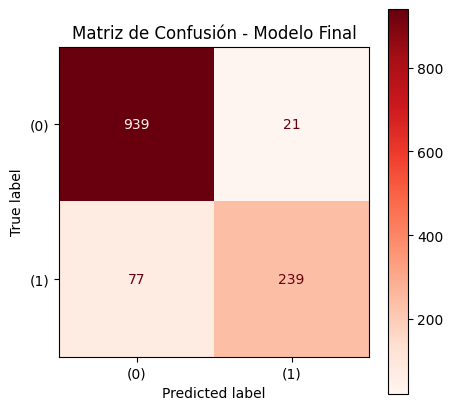

In [ ]:
# Creacion de la matriz de confusión
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["(0)", "(1)"]
)

# Graficar
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(
    cmap="Reds",
    values_format="d",
    ax=ax
)
plt.title("Matriz de Confusión - Modelo Final")
plt.show()

La matriz de confusión del modelo muestra que el clasificador logró un desempeño bastante equilibrado entre las predicciones correctas y los errores. En concreto, el modelo identificó correctamente 939 casos negativos (No Aprobado) y 239 casos positivos (Aprobado). Por otro lado, cometió 21 falsos positivos (casos que fueron clasificados como aprobados, pero en realidad no lo eran) y 77 falsos negativos (casos de estudiantes aprobados que el modelo no logró identificar correctamente).

Estos resultados indican que el modelo presenta una alta capacidad para reconocer correctamente los estudiantes no aprobados, lo cual se refleja en la gran cantidad de verdaderos negativos y en la baja tasa de falsos positivos. Además, el número de verdaderos positivos también es considerable, lo que demuestra que el modelo tiene una buena habilidad para detectar los casos de aprobación, aunque con un pequeño margen de error.

En conjunto, la matriz de confusión evidencia que el modelo mantiene un buen equilibrio entre precisión y sensibilidad, clasificando correctamente la mayoría de los casos. Si bien aún existen algunos falsos negativos, el rendimiento general es sólido y coherente con las métricas globales de desempeño obtenidas (Balanced Accuracy, Recall y F1-Score), lo que confirma que el modelo Random Forest ofrece una clasificación confiable y bien ajustada a los datos disponibles.

## **Support Vector Machine**

In [ ]:
# Modelo base
svc = SVC()

# Definición del grid de hiperparámetros
param_grid = {
    'kernel': ['rbf','sigmoid'],  # los kernels que queremos probar
    'gamma': [0.001, 0.01, 0.1]
}

In [ ]:
# Llamado de la función
grid, scores_folds, balanced_acc_final, mcc_final, precision, recall, f_1, specificity, report, cm, importantes2 = flujo_clasificacion(svc, param_grid, X_train, X_test, y_train, y_test)

In [ ]:
# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor balanced accuracy promedio:", grid.best_score_)

Mejores hiperparámetros: {'gamma': 0.01, 'kernel': 'rbf'}
Mejor balanced accuracy promedio: 0.8596961972730558


In [ ]:
# Balanced accuracy de cada fold del mejor modelo encontrado
print("Balanced Accuracy en cada fold del mejor modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {score:.4f}")

print("\nPromedio:", scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Balanced Accuracy en cada fold del mejor modelo:
Fold 1: 0.8231
Fold 2: 0.8568
Fold 3: 0.8802
Fold 4: 0.8626
Fold 5: 0.8758

Promedio: 0.8597 | Desviación estándar: 0.0202


In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:\n")
print("Balanced Accuracy:", round(balanced_acc_final, 4))

print("Recall:", round(recall, 4))
print("Especificidad:", round(specificity, 4))
print("Precision:", round(precision, 4))
print("F1-Score:", round(f_1, 4))
print("\nClassification Report:")
print(report)

Evaluación final:

Balanced Accuracy: 0.8858
Recall: 0.8101
Especificidad: 0.9615
Precision: 0.8737
F1-Score: 0.8407

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.96      0.95       960
        True       0.87      0.81      0.84       316

    accuracy                           0.92      1276
   macro avg       0.91      0.89      0.90      1276
weighted avg       0.92      0.92      0.92      1276



In [ ]:
## ¿ QUE NOS ESTÁ DICIENDO LAS 5 METRICAS REPORTADAS ANTES (BALANCED, RECALL, ESPECIFICIDAD, PRECISION, F1_SCORE)?

El modelo SVM con kernel RBF (Radial Basis Function) y un valor de γ = 0.01 mostró un rendimiento general muy equilibrado, destacándose por su buena capacidad de clasificación en ambos grupos (aprobados y no aprobados). Las métricas principales obtenidas permiten entender su comportamiento de manera más detallada:



*   Balanced Accuracy (0.8858): indica que el modelo logra un equilibrio sólido entre ambas clases, lo cual es especialmente relevante debido al desbalance del conjunto de datos. En promedio, el modelo acierta casi el 89% de los casos considerando tanto los aprobados como los no aprobados.

*   Recall (0.8101): refleja que el modelo detecta correctamente al 81% de los estudiantes aprobados, es decir, comete pocos falsos negativos. Esto muestra una buena sensibilidad, importante para no dejar fuera a quienes realmente aprueban.

* Especificidad (0.9615): evidencia que el modelo identifica correctamente al 96% de los estudiantes no aprobados, con una tasa muy baja de falsos positivos.

* Precisión (0.8737): significa que, de todos los casos clasificados como “Aprobado”, un 87% lo están efectivamente. Esto demuestra que el modelo no solo detecta bien a los aprobados, sino que sus predicciones son bastante confiables.

* F1-Score (0.8407): al combinar precisión y recall, este valor sugiere un buen balance global entre ambas métricas, lo que confirma que el modelo mantiene una clasificación coherente y estable en los dos grupos.

En términos prácticos, este resultado indica que el modelo aprende patrones más nítidos y generaliza mejor, siendo una opción sólida cuando se busca máxima sensibilidad con alta precisión

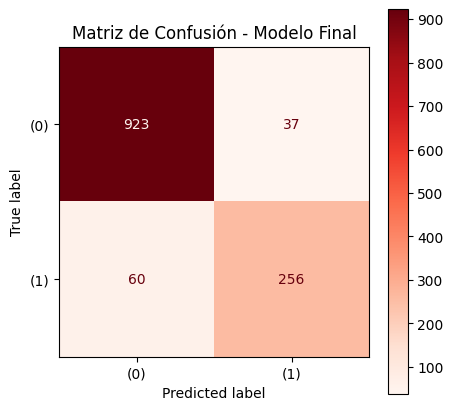

In [ ]:
# Creacion de la matriz de confusión
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["(0)", "(1)"]
)

# Graficar
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(
    cmap="Reds",
    values_format="d",
    ax=ax
)
plt.title("Matriz de Confusión - Modelo Final")
plt.show()

La matriz de confusión permite observar en detalle cómo el modelo clasificó correctamente o incorrectamente las observaciones de cada clase:

* Verdaderos Negativos (923): son los casos correctamente identificados como “no aprobados”. Esto evidencia que el modelo tiene una muy buena capacidad para reconocer a quienes realmente no aprobaron.

* Falsos Positivos (37): son los estudiantes que el modelo clasificó como “aprobados” cuando en realidad no lo estaban. Este número bajo demuestra que el modelo comete pocos errores al predecir aprobaciones falsas, lo que se relaciona directamente con la alta especificidad (0.9615).

* Falsos Negativos (60): representan a los estudiantes que aprobaron, pero el modelo los clasificó como “no aprobados”. Aunque no es un valor alto, muestra que aún hay margen de mejora en la sensibilidad (recall = 0.8101) para detectar todos los aprobados.

* Verdaderos Positivos (256): son los casos correctamente identificados como “aprobados”, lo que respalda la buena capacidad predictiva general del modelo.

En conjunto, la matriz muestra un buen equilibrio entre ambas clases, con un claro predominio de aciertos (923 + 256 = 1179) frente a errores (37 + 60 = 97). Esto confirma la solidez del modelo SVM, que mantiene un excelente rendimiento global, minimizando tanto los falsos positivos como los falsos negativos.

###**¿Todas mis columnas son importantes?**

In [ ]:
display(importantes2.sort_values(by='Importancia', ascending=False))
importantes_copy = importantes2.sort_values(by='Importancia', ascending=False).copy()

,Columna,Importancia
1,Attendance,2.740394e-01
0,Hours_Studied,1.804186e-01
5,Previous_Scores,5.460839e-02
7,Tutoring_Sessions,2.507911e-02
3,Access_to_Resources,2.329048e-02
2,Parental_Involvement,2.325422e-02
12,Parental_Education_Level,1.166930e-02
13,Distance_from_Home,1.140889e-02
6,Motivation_Level,1.000659e-02
8,Family_Income,9.916271e-03


In [ ]:
# Rango ajustable
min_importancia = 0.01 # valor mínimo

# Filtrado las columnas dentro del rango
features_filtradas = importantes_copy[
    (importantes_copy["Importancia"] >= min_importancia)
]["Columna"]

# Filtrado el dataset original X
X_filtrado = X[features_filtradas].copy()

display(X_filtrado.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6377 entries, 0 to 6606
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Attendance                6377 non-null   int64
 1   Hours_Studied             6377 non-null   int64
 2   Previous_Scores           6377 non-null   int64
 3   Tutoring_Sessions         6377 non-null   int64
 4   Access_to_Resources       6377 non-null   int64
 5   Parental_Involvement      6377 non-null   int64
 6   Parental_Education_Level  6377 non-null   int64
 7   Distance_from_Home        6377 non-null   int64
 8   Motivation_Level          6377 non-null   int64
dtypes: int64(9)
memory usage: 498.2 KB


None

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y,
    test_size=0.2,       # 80 train - 20 test
    stratify=y,          # mantiene proporciones del desbalance
    random_state=42
)

In [ ]:
grid, scores_folds, balanced_acc_final, mcc_final, precision, recall, f_1, specificity, report, cm, importantes3 = flujo_clasificacion(svc, param_grid, X_train, X_test, y_train, y_test)

In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:\n")
print("Balanced Accuracy:", round(balanced_acc_final, 4))

print("Recall:", round(recall, 4))
print("Especificidad:", round(specificity, 4))
print("Precision:", round(precision, 4))
print("F1-Score:", round(f_1, 4))
print("\nClassification Report:")
print(report)

Evaluación final:

Balanced Accuracy: 0.8858
Recall: 0.8101
Especificidad: 0.9615
Precision: 0.8737
F1-Score: 0.8407

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.96      0.95       960
        True       0.87      0.81      0.84       316

    accuracy                           0.92      1276
   macro avg       0.91      0.89      0.90      1276
weighted avg       0.92      0.92      0.92      1276



Tras analizar la importancia de las variables, se identificó que las características más relevantes para el modelo fueron Attendance, Hours_Studied, Previous_Scores, Tutoring_Sessions, Access_to_Resources, Parental_Involvement, Parental_Education_Level, Distance_from_Home y Motivation_Level. Sin embargo, al entrenar nuevamente el modelo utilizando únicamente estas variables más significativas, no se observó una mejora en el desempeño general. Las métricas principales, como la balanced accuracy, recall, precisión y F1-score, se mantuvieron prácticamente iguales, lo que sugiere que el modelo original ya lograba capturar adecuadamente la información relevante.

# **Umbral de aprobados por puntaje mayor igual a *60*** - SUPER DESBALANCE


In [ ]:
# Preparacion de del dataset

# copia del DataFrame
df_60 = df_encoded.copy()

# Agregar la columna booleana de aprobados si tiene valor mayor igual a 60
df_60['Aprobados'] = df_60['Exam_Score'] >= 60

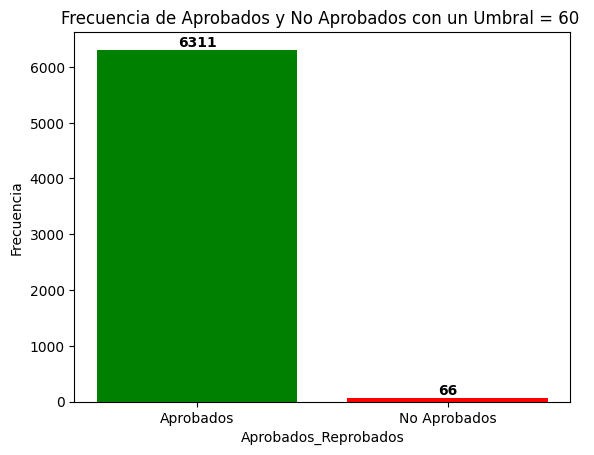

In [ ]:
# @title Visualización de datos por categoría

# Frecuencias por categoría
categorias = df_60['Aprobados'].value_counts()

# Colores para True y False
colores = ['green' if valor else 'red' for valor in categorias.index]

etiquetas = ['Aprobados' if valor else 'No Aprobados' for valor in categorias.index]
plt.bar(etiquetas, categorias.values, color=colores)

# Añadir los valores encima de cada barra
for i, v in enumerate(categorias.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')  # el +50 es para que no se superponga

# Títulos y etiquetas
plt.title('Frecuencia de Aprobados y No Aprobados con un Umbral = 60 ')
plt.xlabel('Aprobados_Reprobados')
plt.ylabel('Frecuencia')

plt.show()

El umbral de 60 genera un dataset muy desequilibrado, con una gran diferencia entre la cantidad de aprobados (6311) y no aprobados (66). Este desequilibrio provoca que el modelo se vuelva sesgado, ya que al existir muchos más casos de aprobados, tenderá a predecir casi siempre esta categoría para obtener una alta precisión. Sin embargo, aunque la exactitud (accuracy) pueda resultar con valores muy buenos, el modelo no será realmente capaz de identificar correctamente a los estudiantes no aprobados, generando resultados engañosos. Además, este desbalance dificulta el proceso de aprendizaje, ya que el modelo dispone de muy poca información sobre los casos minoritarios, lo que limita su capacidad para distinguir entre ambas clases. Es por eso que el desequilibrio generado por el umbral de 60 afecta negativamente el rendimiento del modelo y puede producir sesgos hacia la clase mayoritaria.


In [ ]:
# @title Función de clasificación
def flujo_clasificacion(modelo, param_grid, X_train, X_test, y_train, y_test):

  # Validación cruzada
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  # Tuning con grid_search
  grid = GridSearchCV(
      estimator=modelo,
      param_grid=param_grid,
      cv=cv,
      scoring='balanced_accuracy',
      n_jobs=-1,
      return_train_score=True
  )

  # Entrenamiento del GridSearch
  grid.fit(X_train, y_train)

  # Obtención del mejor modelo
  mejor_modelo = grid.best_estimator_

  # Metricas de cada fold del mejor modelo
  scores_folds = cross_val_score(
      mejor_modelo, X_train, y_train,
      cv=cv,
      scoring=make_scorer(balanced_accuracy_score)
  )

  # Entrenamiento del modelo fina con todo el x_train y evaluar con el test
  mejor_modelo.fit(X_train, y_train)
  y_pred = mejor_modelo.predict(X_test)

  balanced_acc_final = balanced_accuracy_score(y_test, y_pred)
  mcc_final = matthews_corrcoef(y_test, y_pred)

  # Importancia de columnas
  try: # manejo de error para el SVC
    importantes = pd.DataFrame({
        'Columna': X_train.columns,
        'Importancia': mejor_modelo.feature_importances_
    })
  except AttributeError:
    importantes = None
    print("El modelo no tiene un atributo 'feature_importances_'.")

  # Calcular matriz de confusión
  cm = confusion_matrix(y_test, y_pred)

  return grid, scores_folds, balanced_acc_final, mcc_final, classification_report(y_test, y_pred, zero_division=0), cm, importantes

In [ ]:
#@title Primera partición de dataset para evaluar y evitar sobre entrenamiento
X = df_60.drop(['Exam_Score','Aprobados'], axis=1)
y = df_60['Aprobados']

# Partición inicial Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80 train - 20 test
    stratify=y,          # mantiene proporciones del desbalance
    random_state=42
)

Se realiza una partición del dataset en un 80% para entrenamiento (Train) y un 20% para prueba (Test) con el objetivo de evaluar correctamente el rendimiento del modelo y evitar el sobreajuste. El conjunto de entrenamiento se utiliza para que el modelo aprenda los patrones de los datos, mientras que el conjunto de prueba sirve para comprobar su capacidad de generalización con información que no ha visto antes. Además, se aplica la opción stratify para mantener las proporciones de aprobados y no aprobados, garantizando una representación equilibrada de las clases en ambas particiones.

## **Gaussian Bayes**

In [ ]:
# Modelo base
model = GaussianNB()

# Validación cruzada con StratifiedKFold SOLO CON ENTRENAMIENTOS
# Con 5 splits de organizacion
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Obtencion de los resultados de la validación cruzada con metricas puntuales
scores_folds = cross_val_score(
    model, X_train, y_train,
    cv=cv,
    scoring=make_scorer(balanced_accuracy_score)
)

# Balanced accuracy de cada fold del mejor modelo encontrado
print("Balanced Accuracy en cada fold del modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {score:.4f}")

print("\nPromedio:", scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Balanced Accuracy en cada fold del modelo:
Fold 1: 0.7248
Fold 2: 0.5990
Fold 3: 0.6480
Fold 4: 0.8167
Fold 5: 0.7258

Promedio: 0.7029 | Desviación estándar: 0.0745


In [ ]:
# Entrenamiento del modelo fina con todo el x_train y evaluar con el test
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

balanced_acc_final = balanced_accuracy_score(y_test, y_pred)
mcc_final = matthews_corrcoef(y_test, y_pred)

# Evaluacion final
print("Evaluación final:")
print("Balanced Accuracy:", round(balanced_acc_final, 4))
print("Matthews Corrcoef:", round(mcc_final, 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Evaluación final:
Balanced Accuracy: 0.73
Matthews Corrcoef: 0.5852

Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.46      0.57        13
        True       0.99      1.00      1.00      1263

    accuracy                           0.99      1276
   macro avg       0.87      0.73      0.78      1276
weighted avg       0.99      0.99      0.99      1276



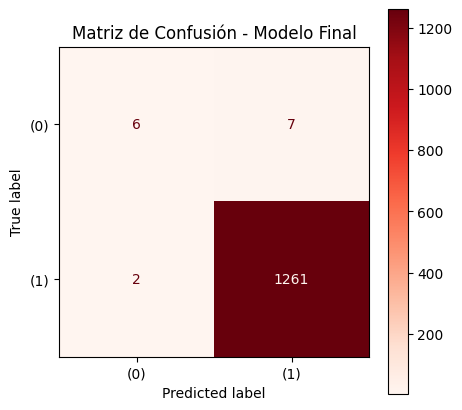

In [ ]:
# Creacion de la matriz de confusión

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["(0)", "(1)"]
)

# Graficar
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(
    cmap="Reds",
    values_format="d",
    ax=ax
)
plt.title("Matriz de Confusión - Modelo Final")
plt.show()

## **Decision Tree**

In [ ]:
# Modelo base
tree = DecisionTreeClassifier(random_state=42)

# Espacio de hiperparámetros para el tuning
param_grid = {
    'max_depth': [1, 2, 3, 5, 7, 10, 20, 30, 50, 100, None]
}

In [ ]:
# Llamado de la función
grid, scores_folds, balanced_acc_final, mcc_final, report, cm, importantes = flujo_clasificacion(tree, param_grid, X_train, X_test, y_train, y_test)

In [ ]:
# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor balanced accuracy promedio:", grid.best_score_)

Mejores hiperparámetros: {'max_depth': 20}
Mejor balanced accuracy promedio: 0.733923018664602


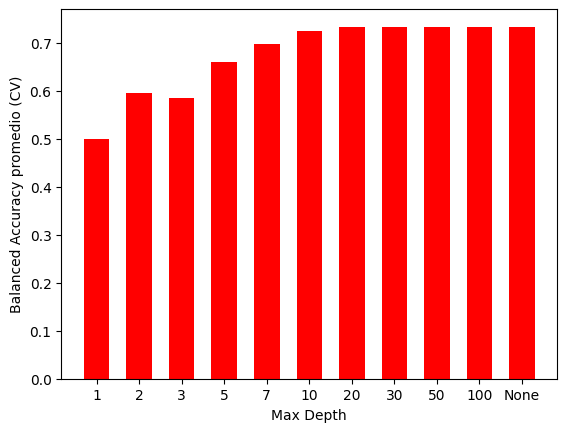

In [ ]:
# Gráfica de los hiperparametros
results = grid.cv_results_
depths = [str(d) if d is not None else "None" for d in param_grid['max_depth']]
scores = results['mean_test_score']

plt.bar(depths, scores, color='red', width= 0.6)
plt.xlabel('Max Depth')
plt.ylabel('Balanced Accuracy promedio (CV)')
plt.show()

In [ ]:
# Balanced accuracy de cada fold del mejor modelo encontrado
print("Balanced Accuracy en cada fold del mejor modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {score:.4f}")

print("\nPromedio:", scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Balanced Accuracy en cada fold del mejor modelo:
Fold 1: 0.7678
Fold 2: 0.6955
Fold 3: 0.8950
Fold 4: 0.6769
Fold 5: 0.6344

Promedio: 0.7339 | Desviación estándar: 0.0914


In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("Balanced Accuracy:", round(balanced_acc_final, 4))
print("Matthews Corrcoef:", round(mcc_final, 4))
print("\nClassification Report:")
print(report)

Evaluación final:
Balanced Accuracy: 0.613
Matthews Corrcoef: 0.2712

Classification Report:
              precision    recall  f1-score   support

       False       0.33      0.23      0.27        13
        True       0.99      1.00      0.99      1263

    accuracy                           0.99      1276
   macro avg       0.66      0.61      0.63      1276
weighted avg       0.99      0.99      0.99      1276



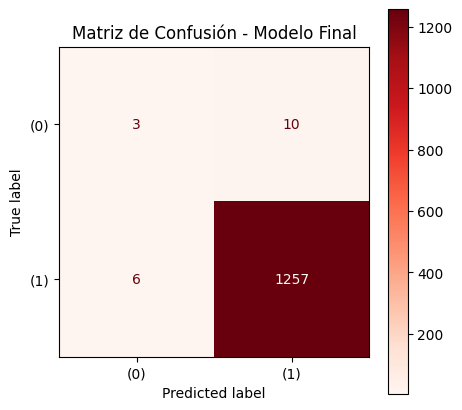

In [ ]:
# Creacion de la matriz de confusión
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["(0)", "(1)"]
)

# Graficar
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(
    cmap="Reds",
    values_format="d",
    ax=ax
)
plt.title("Matriz de Confusión - Modelo Final")
plt.show()

###**¿Todas mis columnas son importantes?**

In [ ]:
display(importantes.sort_values(by='Importancia', ascending=False))

,Columna,Importancia
0,Hours_Studied,0.203607
1,Attendance,0.193117
4,Sleep_Hours,0.084442
3,Access_to_Resources,0.072671
7,Tutoring_Sessions,0.063447
5,Previous_Scores,0.056633
9,Teacher_Quality,0.054974
11,Physical_Activity,0.054903
17,Learning_Disabilities_Yes,0.044634
6,Motivation_Level,0.041976


In [ ]:
# Rango ajustable
min_importancia = 0.01 # valor mínimo

# Filtrado las columnas dentro del rango
features_filtradas = importantes[
    (importantes["Importancia"] >= min_importancia)
]["Columna"]

# Filtrado el dataset original X
X_filtrado = X[features_filtradas]

display(X_filtrado.head())


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Family_Income,Teacher_Quality,Physical_Activity,Parental_Education_Level,Distance_from_Home,School_Type_Public,Learning_Disabilities_Yes
0,23,84,1,3,7,73,1,0,1,2,3,1,1,1,0
1,19,64,1,2,8,59,1,2,2,2,4,2,2,1,0
2,24,98,2,2,7,91,2,2,2,2,4,3,1,1,0
3,29,89,1,2,8,98,2,1,2,2,4,1,2,1,0
4,19,92,2,2,6,65,2,3,2,3,4,2,1,1,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y,
    test_size=0.2,       # 80 train - 20 test
    stratify=y,          # mantiene proporciones del desbalance
    random_state=42
)

In [ ]:
grid, scores_folds, balanced_acc_final, mcc_final, report, cm, importantes = flujo_clasificacion(tree, param_grid, X_train, X_test, y_train, y_test)

In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("Balanced Accuracy:", round(balanced_acc_final, 4))
print("Matthews Corrcoef:", round(mcc_final, 4))
print("\nClassification Report:")
print(report)

Evaluación final:
Balanced Accuracy: 0.6126
Matthews Corrcoef: 0.2565

Classification Report:
              precision    recall  f1-score   support

       False       0.30      0.23      0.26        13
        True       0.99      0.99      0.99      1263

    accuracy                           0.99      1276
   macro avg       0.65      0.61      0.63      1276
weighted avg       0.99      0.99      0.99      1276



## **Random Forest**

In [ ]:
# Modelo base
forest = RandomForestClassifier(random_state=42)

# Espacio de hiperparámetros para el tuning
param_grid = {
    'n_estimators': [2, 5, 10, 50, 100], # numero de arboles a realizar
    'max_depth': [2, 3, 5, 10, 15, 20, None]
}

In [ ]:
# Llamado de la función
grid, scores_folds, balanced_acc_final, mcc_final, report, cm, importantes = flujo_clasificacion(forest, param_grid, X_train, X_test, y_train, y_test)

In [ ]:
# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor balanced accuracy promedio:", grid.best_score_)

Mejores hiperparámetros: {'max_depth': 15, 'n_estimators': 2}
Mejor balanced accuracy promedio: 0.690474103901966


In [ ]:
# Balanced accuracy de cada fold del mejor modelo encontrado
print("Balanced Accuracy en cada fold del mejor modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {score:.4f}")

print("\nPromedio:", scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Balanced Accuracy en cada fold del mejor modelo:
Fold 1: 0.7179
Fold 2: 0.6431
Fold 3: 0.7881
Fold 4: 0.5850
Fold 5: 0.7184

Promedio: 0.6905 | Desviación estándar: 0.0699


In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("Balanced Accuracy:", round(balanced_acc_final, 4))
print("Matthews Corrcoef:", round(mcc_final, 4))
print("\nClassification Report:")
print(report)

Evaluación final:
Balanced Accuracy: 0.6043
Matthews Corrcoef: 0.1361

Classification Report:
              precision    recall  f1-score   support

       False       0.10      0.23      0.14        13
        True       0.99      0.98      0.98      1263

    accuracy                           0.97      1276
   macro avg       0.54      0.60      0.56      1276
weighted avg       0.98      0.97      0.98      1276



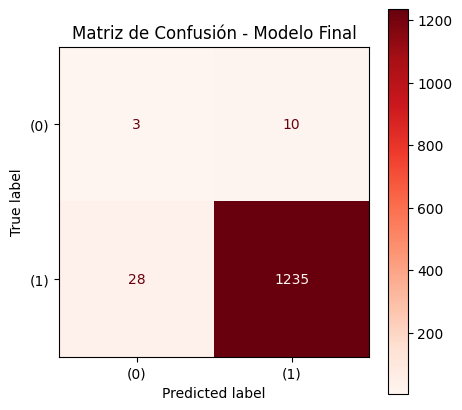

In [ ]:
# Creacion de la matriz de confusión
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["(0)", "(1)"]
)

# Graficar
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(
    cmap="Reds",
    values_format="d",
    ax=ax
)
plt.title("Matriz de Confusión - Modelo Final")
plt.show()

## **Support Vector Machine** -- EN REVISIÓN

In [ ]:
# Modelo base
svc = SVC()

# Definición del grid de hiperparámetros
param_grid = {
    'kernel': ['rbf', 'poly', 'sigmoid'],  # los kernels que queremos probar
}

In [ ]:
# Llamado de la función
grid, scores_folds, balanced_acc_final, mcc_final, report, cm, importantes = flujo_clasificacion(svc, param_grid, X_train, X_test, y_train, y_test)

El modelo no tiene un atributo 'feature_importances_'.


In [ ]:
# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor balanced accuracy promedio:", grid.best_score_)

Mejores hiperparámetros: {'kernel': 'rbf'}
Mejor balanced accuracy promedio: 0.5


In [ ]:
# Balanced accuracy de cada fold del mejor modelo encontrado
print("Balanced Accuracy en cada fold del mejor modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {score:.4f}")

print("\nPromedio:", scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Balanced Accuracy en cada fold del mejor modelo:
Fold 1: 0.5000
Fold 2: 0.5000
Fold 3: 0.5000
Fold 4: 0.5000
Fold 5: 0.5000

Promedio: 0.5 | Desviación estándar: 0.0


In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("Balanced Accuracy:", round(balanced_acc_final, 4))
print("Matthews Corrcoef:", round(mcc_final, 4))
print("\nClassification Report:")
print(report)

Evaluación final:
Balanced Accuracy: 0.5
Matthews Corrcoef: 0.0

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        13
        True       0.99      1.00      0.99      1263

    accuracy                           0.99      1276
   macro avg       0.49      0.50      0.50      1276
weighted avg       0.98      0.99      0.98      1276



# **Umbral de aprobados por puntaje mayor igual a *67***


In [ ]:
# Preparacion de del dataset

# copia del DataFrame
df_60 = df_encoded.copy()

# Agregar la columna booleana de aprobados si tiene valor mayor igual a 70
df_60['Aprobados'] = df_60['Exam_Score'] >= 67

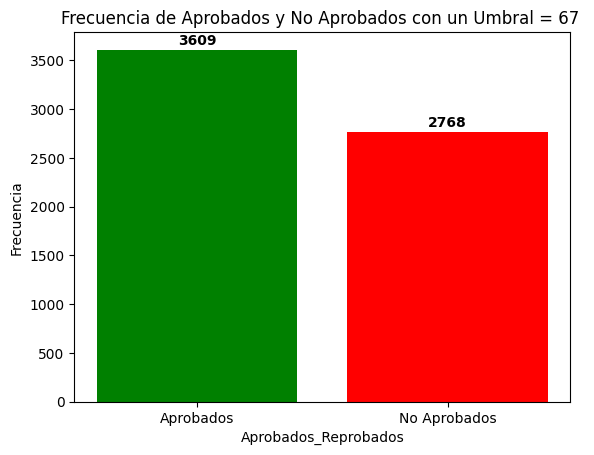

In [ ]:
# @title Visualización de datos por categoría

# Frecuencias por categoría
categorias = df_60['Aprobados'].value_counts()

# Colores para True y False
colores = ['green' if valor else 'red' for valor in categorias.index]

etiquetas = ['Aprobados' if valor else 'No Aprobados' for valor in categorias.index]
plt.bar(etiquetas, categorias.values, color=colores)

# Añadir los valores encima de cada barra
for i, v in enumerate(categorias.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')  # el +50 es para que no se superponga

# Títulos y etiquetas
plt.title('Frecuencia de Aprobados y No Aprobados con un Umbral = 67 ')
plt.xlabel('Aprobados_Reprobados')
plt.ylabel('Frecuencia')

plt.show()

## **Gaussian Bayes**

## **Decision Tree**

## **Random Forest**

## **Support Vector Machine**